# CSC1185 Neural Language Modelling: Week 2 Lab -- Feed Forward Neural Networks

**Feedforward Neural Networks** (FFNs) are a type of artificial neural network useful for more complex NLP tasks than logistic regression (LR), including both classification and language modelling tasks. FNNs consist of layers of interconnected neurons organised into an input layer, one or more hidden layers, and an output layer. Each connection between nodes is associated with a weight, and each neuron computes the weighted sum of its inputs and applies an activation function to the result which gives the unit's output. See the lecture slides and Jurafsky & Martin, Chapter 6 for details.

In this lab, you will code, more or less from scratch, a Feedforward Neural Network and apply it to a topic classification task.

A lot of it should look familiar from the Week 1 lab, as each node and its inputs in an FFN can be thought of as a binary logistic regressor (except that the activation function isn't always the sigmoid).

As in Week 1, we provide a coding framework with a lot of the code in place, for you to add to. At two points during the lab, we will share partial solutions.

The remainder of the lab (for which we don't provide solutions) is for you to complete on your own, and must be submitted for assessment for Week 2 of this module (see handbook).




Troughout this notebook, additional information can be found in the Week 2 lecture slides and Chapter 6 of the book **[Speech and Language Processing (3rd ed. draft)](https://web.stanford.edu/~jurafsky/slp3/6.pdf)** by Dan Jurafsky and James H. Martin.

In [140]:
# %matplotlib inline allows for displaying plots directly in the Jupyter notebook
%matplotlib inline

# NumPy is a library for numerical computations, with support for arrays and matrices
import numpy as np

# tqdm is used for creating progress bars to track the progress of for loops
from tqdm import tqdm

# Matplotlib is a plotting library, and we use it for tracking the loss values across iterations
import matplotlib.pyplot as plt

# make_classification is a function in the scikit-learn library to generate a random classification dataset
from sklearn.datasets import make_classification

# StandardScaler is a function in scikit-learn for normalising (scaling) the features of a dataset
from sklearn.preprocessing import StandardScaler

# train_test_split is a function in scikit-learn for splitting a dataset into training and testing sets
from sklearn.model_selection import train_test_split

# accuracy_score is a function in scikit-learn that implements the accuracy metric to evaluate classification models
from sklearn.metrics import accuracy_score

#TfidfVectorizer class from scikit-learn for text feature extraction using TF-IDF.
from sklearn.feature_extraction.text import TfidfVectorizer

# IPython.display allows clearing the output in a Jupyter notebook cell
from IPython.display import clear_output

# Seed for reproducibility, fixing the random seed ensures consistent results when rerunning the code
seed = 42
np.random.seed(seed)


## 1 Feedforward Neural Networks Implementation


### 1.1 Activation functions -- definition and derivatives

In our implementation, we'll use Sigmoid and Softmax as activation functions:
- **Sigmoid Function:**

  $ \sigma(z) = \frac{1}{1 + e^{-z}}$

  *Derivative (with respect to *z*):*
  $\frac{d}{dz} \sigma(z) = \sigma(z) \cdot (1 - \sigma(z))$

- **Softmax Function:**

  $\text{softmax}(z_k) = \frac{e^{z_k}}{\sum_{j=1}^{K} e^{z_j}}$ , Where k is the number of classes

  *Derivative (with respect to *z*$_k$):*
  $\frac{\partial}{\partial z_k} \text{softmax}(z_k) = \text{softmax}(z_k) \cdot (1 - \text{softmax}(z_k))$

**Note:** As discussed in the lecture, we require the derivatives of all
 function involved in forward propagation. These derivatives indicate how each weight and bias needs to be changed to minimise the loss function, forming the basis for the backward propagation loop for updating the weights and biases.

### 1.2 Backward propagation

The goal of backward propagation is to calculate the change in each weight and bias according to the loss we receive from the forward propagation. We need to change the weights and biases individually, because the loss is a function of all the weights and biases (i.e. many variables), so we use partial derivatives with respect to each weight and bias.

To obtain partial derivative, we need to remember that a neural network is a composition of layers and each layer applies an activation function to the weighted sum of its inputs in order to compute its output. To get the derivative of each weight and bias, we apply a technique called the chain rule (see lecture slides and Jurafsky & Martin).

The chain rule is a fundamental rule in calculus that describes how to find derivatives of composite functions. Mathematically, it can be stated as follows.

For example, suppose we have two functions, $u$ and $v$, and their composition $f(x) = u(v(x))$. If both $u$ and $v$ are differentiable, then the derivative of $f$ with respect to $x$ is given by the product of the derivative of $u$ with respect to $v(x)$ and the derivative of $v$ with respect to $x$:

$\frac{df}{dx} = \frac{du}{dv} \cdot \frac{dv}{dx}$

The chain rule can be extended to more than two functions, for example consider $f(x) = u(v(w(x)))$, the derivative of $f(x)$ is:

$\frac{df}{dx} = \frac{du}{dv} \cdot \frac{dv}{dw} \cdot \frac{dw}{dx}$

In the forward propagation, for a 3-layer FFN with sigmoid in the first two layers and softmax in the last layer we have:

$z^{[1]} = W^{[1]}a^{[0]} + b^{[1]}$

$a^{[1]} = \text{sigmoid}(z^{[1]})$

$z^{[2]} = W^{[2]}a^{[1]} + b^{[2]}$

$a^{[2]} = \text{sigmoid}(z^{[2]})$

$z^{[3]} = W^{[3]}a^{[2]} + b^{[3]}$

$a^{[3]} = \text{softmax}(z^{[3]})$

So, in the backward propagation step, we carry out the following backward differentiation computations to obtain our gradients for each weight and bias in each of the three layers (in the lecture, we did this also via computation graphs; for additional explanation see Jurafsky & Martin):


**Output Layer:**

* *Derivative (with respect to $(z^{[3]}$)):*

    $\frac{\partial L}{\partial z^{[3]}} = \frac{\partial \text{softmax}}{\partial z^{[3]}} = \text{softmax}(z^{[3]}) - y_{\text{true}}$

* *Derivative (with respect to $(W^{[3]}$)):*

    $\frac{\partial L}{\partial W^{[3]}} = \frac{\partial z^{[3]}}{\partial W^{[3]}} \cdot \frac{\partial L}{\partial z^{[3]}} = (a^{[2]})^T \cdot \frac{\partial L}{\partial z^{[3]}}$

* *Derivative (with respect to $(b^{[3]}$)):*

    $\frac{\partial L}{\partial b^{[3]}} = \frac{\partial z^{[3]}}{\partial b^{[3]}} \cdot \frac{\partial L}{\partial z^{[3]}} = \sum \frac{\partial L}{\partial z^{[3]}}$

**Hidden Layer 2:**

* *Derivative (with respect to $(z^{[2]}$)):*

    $\frac{\partial L}{\partial z^{[2]}} = \frac{\partial L}{\partial z^{[3]}} \cdot (W^{[3]})^T \cdot \frac{\partial \text{sigmoid}}{\partial z^{[2]}} = \frac{\partial L}{\partial z^{[3]}} \cdot (W^{[3]})^T \cdot \text{sigmoid}'(z^{[2]})$

where $\frac{\partial L}{\partial z^{[3]}} \cdot (W^{[3]})^T$ is the error from Output Layer and $\text{sigmoid}'$ is the derivative of the sigmoid function.

* *Derivative (with respect to $(W^{[2]}$)):*

    $\frac{\partial L}{\partial W^{[2]}} = \frac{\partial z^{[2]}}{\partial W^{[2]}} \cdot \frac{\partial L}{\partial z^{[2]}} = (a^{[1]})^T \cdot \frac{\partial L}{\partial z^{[2]}}$

* *Derivative (with respect to $(b^{[2]}$)):*

    $\frac{\partial L}{\partial b^{[2]}} = \frac{\partial z^{[2]}}{\partial b^{[2]}} \cdot \frac{\partial L}{\partial z^{[2]}} = \sum \frac{\partial L}{\partial z^{[2]}}$

**Hidden Layer 1:**

* *Derivative (with respect to $(z^{[1]}$)):*

    $\frac{\partial L}{\partial z^{[1]}} = \frac{\partial L}{\partial z^{[2]}} \cdot (W^{[2]})^T \cdot \frac{\partial \text{sigmoid}}{\partial z^{[1]}} = \frac{\partial L}{\partial z^{[2]}} \cdot (W^{[2]})^T \cdot \text{sigmoid}'(z^{[1]})$

where $\frac{\partial L}{\partial z^{[2]}} \cdot (W^{[2]})^T$ is the error from Hidden Layer 2.

* *Derivative (with respect to $(W^{[1]})$):*

    $\frac{\partial L}{\partial W^{[1]}} = \frac{\partial z^{[1]}}{\partial W^{[1]}} \cdot \frac{\partial L}{\partial z^{[1]}} = X^T \cdot \frac{\partial L}{\partial z^{[1]}}$

* *Derivative (with respect to $(b^{[1]})$):*

    $\frac{\partial L}{\partial b^{[1]}} = \frac{\partial z^{[1]}}{\partial b^{[1]}} \cdot \frac{\partial L}{\partial z^{[1]}} = \sum \frac{\partial L}{\partial z^{[1]}}$


### 1.3 Network definition

To recap from the lecture, creating a feedforward neural network and training it involves the following steps:

1. **Initialise Layers:**
   - For each layer, initialise a weight matrix and a bias vector:
      - The weight matrix (**W**) size is (input features size, output features size).
      - The bias vector (**b**) size is (1, output features size).

2. **Define Activation Functions for Hidden Layers:**
   - Choose activation functions for hidden layers. Common choices include:
      - [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function)
      - [Softmax](https://en.wikipedia.org/wiki/Softmax_function)
      - [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)

3. **Define Forward Propagation Function:**
   - Implement a function that computes the output of the neural network given an input by applying activation functions to the weighted sums of inputs at each layer.

4. **Define Loss Function:**
   - Choose a loss function that measures the distance between predicted and gold outputs. Common choices include mean squared error for regression tasks and cross-entropy loss for classification tasks.

5. **Define Backward Propagation Function:**
   - Implement a function that computes the gradients of the loss with respect to the weights and biases by applying the chain rule of calculus.

6. **Define Training Loop:**
   - Iterate through the training data multiple times, performing the following in each iteration:
      - Forward pass to compute predictions.
      - Compute loss using the chosen loss function.
      - Backward pass to compute gradients.
      - Update weights and biases using an optimisation algorithm (e.g., gradient descent).
      - Repeat until the loss converges or a predefined number of iterations are reached.

It's good practice to implement neural network architectures using the class data structure in Python for reusability. This allows training multiple instances with different hyperparameters and facilitates debugging in case of issues. Following this practice, below we implement our feedforward neural network as a class, incorporating the steps above.

**Note:** We will label our neural network weights and biases using the following notational convention: **W1**, **b1**, which denote the weights and bias of the first (hidden) layer, respectively. Also, we have **z1** and **a1** denoting the weighted sum of the input plus the bias (result of multiplying the layer input with the layer weights and adding the bias term), and the activation (result of passing **z1** through the activation function), of the first layer, respectively. When calculating gradients, we will use the prefix 'd' to indicate a derivative.

The cell below contains your first coding task for this lab where in the `forward` function you need to add code to compute Z_i and a_i values for each layer i.

In [141]:
class FeedforwardNeuralNetwork:
    # Step 1: Initialise weights and biases
    def __init__(self, input_size: int, hidden_size1: int, hidden_size2: int, output_size: int) -> None:
        '''
        Initialises the neural network with random weights and zero biases.

        Args:
          input_size (int): Number of features in the input data.
          hidden_size1 (int): Number of neurons in the first hidden layer.
          hidden_size2 (int): Number of neurons in the second hidden layer.
          output_size (int): Number of classes in the output layer.
        '''

        # Layer 1
        # Layer 1 weights matrix: (input_size, hidden_size1)
        self.W1 = np.random.randn(input_size, hidden_size1)
        print("Weights layer 1 shape:", self.W1.shape) # -> (1500, 64)
        self.b1 = np.zeros((1, hidden_size1))

        # Layer 2
        # Layer 2 weights matrix: (hidden_size1, hidden_size2)
        self.W2 = np.random.randn(hidden_size1, hidden_size2)
        print("Weights layer 2 shape:", self.W2.shape) # -> (64, 32)
        self.b2 = np.zeros((1, hidden_size2))

        # Layer 3 (Output layer)
        # Layer 3 weights matrix: (hidden_size2, output_size)
        self.W3 = np.random.randn(hidden_size2, output_size)
        print("Weights layer 3 shape:", self.W3.shape) # -> (32, 3)
        self.b3 = np.zeros((1, output_size))


    # Step 2: Activation Functions
    # 2.1: activation functions
    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """
          Sigmoid function that gives us the predictions of the given samples.

          Args:
              Z (array): each row contains z = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n

          Returns:
              np.ndarray: array containing a prediction for each sample.
        """
        return 1 / (1 + np.exp(-z))

    def softmax(self, z: np.ndarray) -> np.ndarray:
        """
          Softmax function that gives us the predictions of the given samples.

          Args:
              Z (array): each row contains z = b + w_1 x_1 + w_2 x_2 + ... + w_n x_n

          Returns:
              np.ndarray: array containing a prediction for each sample.
        """
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    # 2.2: derivatives of activation functions
    def d_sigmoid(self, x: np.ndarray) -> np.ndarray:
      return x * (1 - x)

    # Step 3: Perform Forward propagation
    def forward(self, X: np.ndarray, epoch: int=0) -> np.ndarray:
        '''
        Performs forward propagation for the neural network.

        Args:
            X (numpy.ndarray): Input data with dimensions (num_samples, num_features).

        Returns:
            numpy.ndarray: Output predictions after passing through the network's layers.
        '''

        ## INSERT YOUR CODE HERE ##

        # Layer 1

        # Compute Z for Layer 1 using input data and Layer 1 weights
        # X: (num_train_samples, num_features) x weights layer 1: (input_size, hidden_size1) -> Z1: (num_train_samples, hidden_size1)
        Z1 = np.dot(X, self.W1) + self.b1

        # Compute the output of Layer 1 using the activation function of Layer 1 and Layer 1 Z
        # Z1: (num_train_samples, hidden_size1) -> a1: (num_train_samples, hidden_size1)
        self.a1 = self.sigmoid(Z1)

        if epoch == 0:
          print("Z1 shape (num_train_samples, hidden_size1):", Z1.shape)  # -> (4500, 64)
          print("a1 shape (num_train_samples, hidden_size1):", self.a1.shape)  # -> (4500, 64)


        # Layer 2

        # Compute Z for Layer 2 using output of Layer 1 and Layer 2 weights
        # a1: (num_train_samples, hidden_size1) x weights layer 2: (hidden_size1, hidden_size2) -> Z2: (num_train_samples, hidden_size2)
        Z2 = np.dot(self.a1, self.W2) + self.b2

        # Compute the output of Layer 2 using the activation function of Layer 2 and Layer 2 Z
        # Z2: (num_train_samples, hidden_size2) -> a2: (num_train_samples, hidden_size2)
        self.a2 = self.sigmoid(Z2)

        if epoch == 0:
          print("Z2 shape (num_train_samples, hidden_size2):", Z2.shape)  # -> (4500, 32)
          print("a2 shape (num_train_samples, hidden_size2):", self.a2.shape)  # -> (4500, 32)


        # Layer 3 (Output Layer)

        # Compute Z for Layer 3 using output of Layer 2 and Layer 3 weights
        # a2: (num_train_samples, hidden_size2) x weights layer 3: (hidden_size2, output_size) -> Z3: (num_train_samples, output_size)
        Z3 = np.dot(self.a2, self.W3) + self.b3

        # Compute the output of Layer 3 (output of the network) using the activation function of Layer 3 and Layer 3 Z
        # Z3: (num_train_samples, output_size) -> a3: (num_train_samples, output_size)
        self.a3 = self.softmax(Z3)

        if epoch == 0:
          print("Z3 shape (num_train_samples, output_size):", Z3.shape)  # -> (4500, 3)
          print("a3 shape (num_train_samples, output_size):", self.a3.shape)  # -> (4500, 3)

        ## END OF YOUR CODE ##

        return self.a3


    # Step 4: Cross-Entropy Loss Calculation
    def cross_entropy_loss(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        '''
        Computes the cross-entropy loss between the true labels and predicted probabilities.

        Args:
          y_true (numpy.ndarray): True class labels with dimensions (num_samples,).
          y_pred (numpy.ndarray): Predicted probabilities with dimensions (num_samples, num_classes).

        Returns:
          float: Cross-entropy loss.
        '''
        num_samples = len(y_true)
        loss = -np.sum(np.log(y_pred[np.arange(num_samples), y_true])) / num_samples
        return loss


    # Step 6: Perform Backward propagation
    def backward(self, X: np.ndarray, y_true: np.ndarray, learning_rate: float=0.01, epoch: int=1) -> None:
        '''
        Computes the cross-entropy loss between the true labels and predicted probabilities.

        Args:
          X (numpy.ndarray): Samples in the dataset.
          y_true (numpy.ndarray): True class labels with dimensions (num_samples,).
          learning_rate (float): Learning rate used to update weights. Deafulto to 0.01.
          epoch (int): current epoch during training, used to print matrix weights only for first epoch. Default to 1.
        '''

        num_samples = len(X)

        # 5.1 Compute Gradients for Layer 3 (Output Layer) (d_a3, d_W3, d_b3):
        '''
        d_a3: Calculate the error at the output layer by subtracting 1
         from the predicted probabilities corresponding to the true class.

        d_W3: Compute the gradient of the loss with respect to the weights connecting
         the third layer (output layer) to the second layer.

        d_b3: Compute the gradient of the loss with respect to the biases of the output layer.
        '''
        d_a3 = self.a3.copy()
        d_a3[np.arange(num_samples), y_true] -= 1
        d_L3 = d_a3/ num_samples

        d_W3 = np.dot(self.a2.T, d_L3)
        d_b3 = np.sum(d_L3, axis=0, keepdims=True)
        if epoch == 0:
          print("d_a3 shape (num_train_samples, output_size):", d_a3.shape)  # -> (4500, 3)
          print("d_L3 shape (num_train_samples, output_size):", d_L3.shape)  # -> (4500, 3)
          print("d_W3 shape (hidden_size2, output_size):", d_W3.shape)  # -> (32, 3)
          print("d_b3 shape (1, output_size):", d_b3.shape)  # -> (1, 3)

        # 5.2 Compute Gradients for Layer 2 (d_a2, d_W2, d_b2):
        '''
        d_a2: Calculate the error at the hidden layer .

        d_W2: Compute the gradient of the layer 3 output with respect to the weights connecting
         the second layer (hidden layer) to the first layer (input layer).

        d_b2: Compute the gradient of the layer 3 output with respect to the biases of the hidden layer.
        '''
        d_a2 = np.dot(d_L3, self.W3.T)
        d_L2 = d_a2 * (self.d_sigmoid(self.a2))

        d_W2 = np.dot(self.a1.T, d_L2)
        d_b2 = np.sum(d_L2, axis=0, keepdims=True)
        if epoch == 0:
          print("d_a2 shape (num_train_samples, hidden_size2):", d_a2.shape)  # -> (4500, 32)
          print("d_L2 shape (num_train_samples, hidden_size2):", d_L2.shape)  # -> (4500, 32)
          print("d_W2 shape (hidden_size1, hidden_size2):", d_W2.shape)  # -> (64, 32)
          print("d_b2 shape (1, hidden_size2):", d_b2.shape)  # -> (1, 32)

        # 5.3 Compute Gradients for Layer 1 (d_a1, d_W1, d_b1):
        d_a1 = np.dot(d_L2, self.W2.T)
        d_L1 = d_a1 * (self.d_sigmoid(self.a1))

        d_W1 = np.dot(X.T, d_L1)
        d_b1 = np.sum(d_L1, axis=0, keepdims=True)
        if epoch == 0:
          print("d_a1 shape (num_train_samples, hidden_size1):", d_a1.shape)  # -> (4500, 64)
          print("d_L1 shape (num_train_samples, hidden_size1):", d_L1.shape)  # -> (4500, 64)
          print("d_W1 shape (input_size, hidden_size2):", d_W1.shape)  # -> (1500, 64)
          print("d_b1 shape (1, input_size):", d_b1.shape)  # -> (1, 64)

        # 5.4 Update weights and biases
        self.W1 -= learning_rate * d_W1
        self.b1 -= learning_rate * d_b1
        self.W2 -= learning_rate * d_W2
        self.b2 -= learning_rate * d_b2
        self.W3 -= learning_rate * d_W3
        self.b3 -= learning_rate * d_b3

    # Step 6: Training Loop
    def train(self, X: np.ndarray, y_true: np.ndarray, epochs: int=100, learning_rate: float=0.01) -> None:
        '''
        Trains the neural network using the specified training data.

        Args:
            X (numpy.ndarray): Input data with dimensions (num_samples, num_features).
            y_true (numpy.ndarray): True class labels with dimensions (num_samples,).
            epochs (int): Number of training epochs. Default to 100.
            learning_rate (float): Learning rate for weight updates. Default to 0.01.
        '''
        self.losses = []

        # tqdm is a function that given a list, the total number of iterations and a description,
        # returns a progressbar showing the time execution
        # pbar will be updated to include the loss at each epoch
        pbar = tqdm(range(epochs), total=epochs, desc="Training")
        for epoch in pbar:
              # 6.1 Forward pass
              y_pred = self.forward(X, epoch)

              # 6.2 Compute loss
              loss = self.cross_entropy_loss(y_true, y_pred)
              self.losses.append(loss)
              # updated the progressbar to include the loss of this epoch
              pbar.set_description(f'Training - Epoch {epoch + 1}/{epochs}, Loss: {loss:0.03f}') #0.03f to display the first decimal points

              # 6.3 Backward pass
              self.backward(X, y_true, learning_rate, epoch)


    def show_learning_curve(self) -> None:
        '''
        Displays the learning curve (loss curve) during training.
        '''
        plt.plot(self.losses)
        plt.xlabel('Epochs') # x axis label
        plt.ylabel('Cross-Entropy Loss') # y axis label
        plt.show()


    def test(self, X: np.ndarray) -> np.ndarray:
        '''
        Calculates the predictions for the given samples.

        Args:
            X (numpy.ndarray): Input data with dimensions (num_samples, num_features).

        Returns:
            numpy.ndarray: Output predictions after passing through the network's layers.
        '''
        y_pred = self.forward(X)
        return y_pred

While constructing your neural network, especially for larger ones that can be expensive to train, best practice is to run it using a dummy dataset. This allows you to ensure that everything is working as intended before committing to training on a real dataset.

In [142]:
# Example usage
# Assuming X is the input data (features) and y is the target labels
# For simplicity, let's assume X and y have the following shapes
X = np.random.randn(4500, 1500)  # Dummy input data
y = np.random.randint(0, 3, size=(4500,))  # Dummy target labels (3 classes)

print('Shape of dataset:', X.shape)

Shape of dataset: (4500, 1500)


In [143]:
# Print first 10 samples in the dataset
X[:10]

array([[ 0.49671415, -0.1382643 ,  0.64768854, ...,  1.20836623,
         1.02406253,  0.59252695],
       [ 0.77836108, -0.55118572, -0.81819888, ..., -1.24176058,
         0.33417642, -0.15525905],
       [-1.90780756, -0.86038501, -0.41360553, ...,  1.07684814,
        -2.16967742, -1.1941894 ],
       ...,
       [ 1.54132114,  1.33399819,  0.77773505, ...,  0.83801405,
        -0.10069587, -0.94631382],
       [ 1.17481406, -1.87898094, -0.32779506, ...,  1.28625209,
         0.12118215, -0.20265326],
       [ 0.43084601,  0.23654219,  0.76706269, ...,  1.31220799,
        -0.88410914, -0.15378517]], shape=(10, 1500))

In [144]:
# Initialise the neural network
input_size = X.shape[1]
hidden_size1 = 64
hidden_size2 = 32
output_size = np.max(y) + 1  # Assuming class labels are 0, 1, 2, ...

model = FeedforwardNeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

Weights layer 1 shape: (1500, 64)
Weights layer 2 shape: (64, 32)
Weights layer 3 shape: (32, 3)


In [145]:
# Execute a forward step to check your code
predictions = model.forward(X)

Z1 shape (num_train_samples, hidden_size1): (4500, 64)
a1 shape (num_train_samples, hidden_size1): (4500, 64)
Z2 shape (num_train_samples, hidden_size2): (4500, 32)
a2 shape (num_train_samples, hidden_size2): (4500, 32)
Z3 shape (num_train_samples, output_size): (4500, 3)
a3 shape (num_train_samples, output_size): (4500, 3)


After completing the above code, you can execute the entire training:

Training - Epoch 15/250, Loss: 3.466:   4%|▎         | 9/250 [00:00<00:02, 85.57it/s]

Z1 shape (num_train_samples, hidden_size1): (4500, 64)
a1 shape (num_train_samples, hidden_size1): (4500, 64)
Z2 shape (num_train_samples, hidden_size2): (4500, 32)
a2 shape (num_train_samples, hidden_size2): (4500, 32)
Z3 shape (num_train_samples, output_size): (4500, 3)
a3 shape (num_train_samples, output_size): (4500, 3)
d_a3 shape (num_train_samples, output_size): (4500, 3)
d_L3 shape (num_train_samples, output_size): (4500, 3)
d_W3 shape (hidden_size2, output_size): (32, 3)
d_b3 shape (1, output_size): (1, 3)
d_a2 shape (num_train_samples, hidden_size2): (4500, 32)
d_L2 shape (num_train_samples, hidden_size2): (4500, 32)
d_W2 shape (hidden_size1, hidden_size2): (64, 32)
d_b2 shape (1, hidden_size2): (1, 32)
d_a1 shape (num_train_samples, hidden_size1): (4500, 64)
d_L1 shape (num_train_samples, hidden_size1): (4500, 64)
d_W1 shape (input_size, hidden_size2): (1500, 64)
d_b1 shape (1, input_size): (1, 64)


Training - Epoch 250/250, Loss: 1.769: 100%|██████████| 250/250 [00:02<00:00, 114.04it/s]


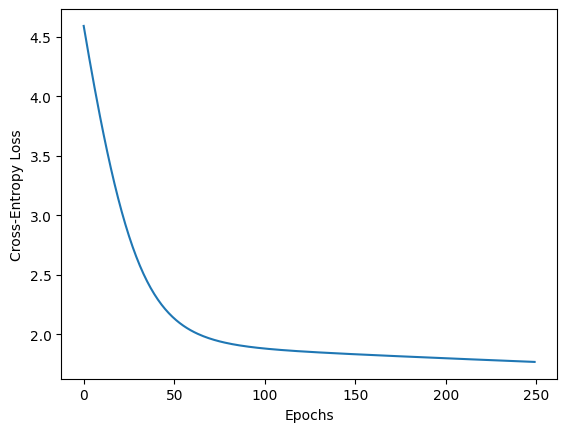

In [146]:
# Train the model
model.train(X, y, epochs=250, learning_rate=0.01)
model.show_learning_curve()

Seems our Feedforward neural networks is working as intended, now let's move forward and train a classification model using a real world dataset.

## 2 Train a text classifcation model with FFNs

#### 2.1 Obtain Ddataset

Instead of creating a toy dataset as we did in Section 1.1, in this section we'll use a real world dataset.

We use the **[AGnews dataset](https://https://huggingface.co/datasets/ag_news)** composed of news articles categorised by domain of the article. The dataset contains 4 categories: *World*; *Sports*, *Business*, and *Science/Technology*.

The dataset is comes ready divided into training and test set containing 120K and 7.6K samples, respectively.

For this exercise, we are going to exclude the World category.

First, we download all the files composing the dataset.

In [147]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1QfAUt0u4wLZVy2Ta1G90jOLNaqzAw2eW' -O agnews_test.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1UsOBTnfch-Su4kqmkzXcIizwJt6NWtXZ' -O agnews_train.csv
clear_output()

In [148]:
import pandas as pd

# labels contained in the dataset
labels = ['sports', 'business', 'science']

# dataset is saved in a CSV file with no header and each column in separated by comma
# the file has the following structure:
# gold_label , title , body
df = pd.read_csv('agnews_train.csv', header=None)

# in the dataset gold labels are given as: 1 (World), 2 (Sports), 3 (Business), 4 (Science/Technology)
# we discard all the rows with gold label 1 (World) and we keep all the other rows
df = df[df[0] != 1]

# we create a 'label' column, subtract 2 from each gold label so we obtain a direct mapping with our list of labels:
# 0 -> sports ; 1 -> business ; 2 -> science
df['label'] = df[0]-2

# we concatenate title and body to obtain a unified text
df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
# remove the original 3 columns to obtain our final processed dataset, containing 2 columns: label and text
# the original 3 columns are the unmatched labels, the titles and the bodies
processed_df = df.drop(columns=[0,1,2])
processed_df.head(10)

,label,text
0,1,Wall St. Bears Claw Back Into the Black (Reute...
1,1,Carlyle Looks Toward Commercial Aerospace (Reu...
2,1,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,1,Iraq Halts Oil Exports from Main Southern Pipe...
4,1,"Oil prices soar to all-time record, posing new..."
5,1,"Stocks End Up, But Near Year Lows (Reuters) Re..."
6,1,Money Funds Fell in Latest Week (AP) AP - Asse...
7,1,Fed minutes show dissent over inflation (USATO...
8,1,Safety Net (Forbes.com) Forbes.com - After ear...
9,1,Wall St. Bears Claw Back Into the Black NEW Y...


In [149]:
X_train, _, y_train, _ = train_test_split(processed_df['text'], processed_df['label'], test_size=0.95, random_state=seed, stratify=processed_df['label'])

#### 2.2 Create Features

When working with text data, we need to convert the text into numerical features that can be fed into the model. There are many approaches for representing text data as features. In the Week 1 lab, we used features such as the natural logarithm of text length, and the number of sport-related words, etc. Here, we'll leverage TF-IDF as a more informative feature that can help our model to perform better. TF-IDF reflects the importance of a word in a document relative to a collection of documents (corpus).

[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for Term Frequency-Inverse Document Frequency, is a numerical statistical technique used to generate features from texts. Let's break down TF-IDF into two components: Term Frequency (TF) and Inverse Document Frequency (IDF).

**Term Frequency (TF):**
TF measures how frequently a term (word) appears in a document. It's a local measure that focuses on the importance of a word within a specific document. The formula for TF is:

$\text{TF}(t, d) = \frac{\text{Number of times term } t \text{ appears in document } d}{\text{Total number of terms in document } d}$

In other terms, it's the ratio of the number of times a specific word occurs in a document to the total number of words in that document. TF values are higher for words that appear frequently in the document.

**Inverse Document Frequency (IDF):**
IDF measures the importance of a term across the entire corpus. It provides a global measure of the rarity of a term. The formula for IDF is:

$\text{IDF}(t, D) = \log\left(\frac{\text{Total number of documents in the corpus } N}{\text{Number of documents containing term } t + 1}\right)$

In other terms, it's the logarithmically scaled inverse fraction of the number of documents containing the term *t* to the total number of documents in the corpus. The addition of 1 in the denominator prevents division by zero when a term does not appear in any document. The logarithmic scaling helps to smooth the values.

**TF-IDF:**
TF-IDF is the product of TF and IDF. The combination of these two components gives a score that reflects the importance of a word in a specific document relative to the entire corpus. The formula for TF-IDF is:

$\text{TF-IDF}(t, d, D) = \text{TF}(t, d) \times \text{IDF}(t, D)$

In practice, words with a higher TF-IDF score are those that appear frequently in a specific document (high TF) but rarely across the entire corpus (high IDF). This approach emphasises words that are unique to a document while downplaying common words appearing frequently across many documents. [Check out this youtube video](https://youtu.be/zLMEnNbdh4Q?feature=shared).

To implement TF-IDF, you can use  [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from scikit-learn.

The next coding task is for you to create a `TfidfVectorizer` instance and transform the training data inputs with it. Note that `TfidfVectorizer` will build a vocabulary that only considers the top `max_features` terms ordered by term frequency across the corpus. If `max_features` is not specified, all terms are used.

In [150]:
# construct a new feature matrix containing the features calculated using TD-IDF
# Create TF-IDF features

## INSERT YOUR CODE HERE ##
from sklearn.feature_extraction.text import TfidfVectorizer

def get_features_text(text: pd.Series, max_features: int, vectoriser=None):
    """
    Calculate text features for the given text using TF-IDF with the given maximum number of features.

    Args:
        text (pd.Series): a column of texts in a pandas dataframe.
        max_features (int): TF-IDF vectoriser instance.

    Returns:
        Matrix: TF-IDF Features extracted from the text.
    
    If vectoriser is None, create and fit a new one (training).
    Otherwise, use the provided vectoriser (testing).
    """
    if vectoriser is None:
        # Training: create new vectorizer and fit_transform
        vectoriser = TfidfVectorizer(max_features=max_features)
        tfidf_features_matrix = vectoriser.fit_transform(text)
        return tfidf_features_matrix, vectoriser
    else:
        # Testing: use existing vectorizer, transform only
        tfidf_features_matrix = vectoriser.transform(text)
        return tfidf_features_matrix

## END OF YOUR CODE ##

max_features = 1500  # Adjust max_features as needed
train_TD_IDF_features, tfidf_vectoriser =  get_features_text(X_train, max_features)

In [151]:
# TfidfVectorizer returns a sparse matrix, we need to convert this matrix into a numpy array to pass it trough our Neural Network
# the todense() function allows us to convert the dense matrix into a list that we convert to a numpy array using np.array()
X_train = np.array(train_TD_IDF_features.todense())

print(f"Shape of train dataset after computing TD-IDF features for each text: {train_TD_IDF_features.shape}")
# -> (4500, 1500)

Shape of train dataset after computing TD-IDF features for each text: (4500, 1500)


### 2.2 Initialise a new instance of FeedforwardNeuralNetwork and set the the proper sizes

The next coding task is for you to create a new instance of the `FeedforwardNeuralNetwork` class, instantiate the network with correct layer sizes and train it on the vectorised training data.

Weights layer 1 shape: (1500, 64)
Weights layer 2 shape: (64, 32)
Weights layer 3 shape: (32, 3)


Training - Epoch 20/250, Loss: 2.326:   5%|▍         | 12/250 [00:00<00:02, 117.18it/s]

Z1 shape (num_train_samples, hidden_size1): (4500, 64)
a1 shape (num_train_samples, hidden_size1): (4500, 64)
Z2 shape (num_train_samples, hidden_size2): (4500, 32)
a2 shape (num_train_samples, hidden_size2): (4500, 32)
Z3 shape (num_train_samples, output_size): (4500, 3)
a3 shape (num_train_samples, output_size): (4500, 3)
d_a3 shape (num_train_samples, output_size): (4500, 3)
d_L3 shape (num_train_samples, output_size): (4500, 3)
d_W3 shape (hidden_size2, output_size): (32, 3)
d_b3 shape (1, output_size): (1, 3)
d_a2 shape (num_train_samples, hidden_size2): (4500, 32)
d_L2 shape (num_train_samples, hidden_size2): (4500, 32)
d_W2 shape (hidden_size1, hidden_size2): (64, 32)
d_b2 shape (1, hidden_size2): (1, 32)
d_a1 shape (num_train_samples, hidden_size1): (4500, 64)
d_L1 shape (num_train_samples, hidden_size1): (4500, 64)
d_W1 shape (input_size, hidden_size2): (1500, 64)
d_b1 shape (1, input_size): (1, 64)


Training - Epoch 250/250, Loss: 1.326: 100%|██████████| 250/250 [00:02<00:00, 114.18it/s]


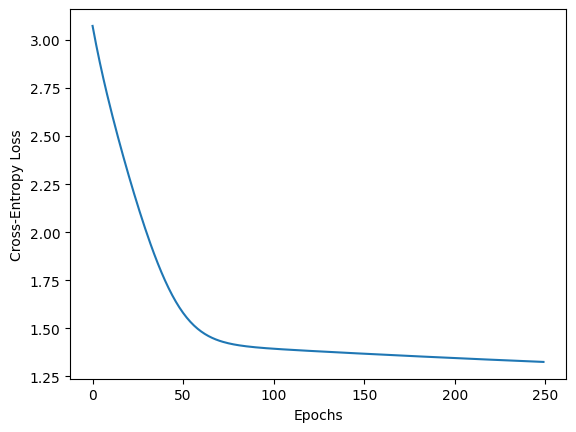

In [152]:
# Hyperparameters definition
input_size = X_train.shape[1]
hidden_size1 = 64
hidden_size2 = 32
output_size = np.max(y_train) + 1  # Assuming class labels are 0, 1, 2, ...

learning_rate = 0.01
epochs = 200

## INSERT YOUR CODE HERE ##

# Instantiate the network with the correct layer sizes
model = FeedforwardNeuralNetwork(input_size, hidden_size1, hidden_size2, output_size)

# Execute a forward step to check your code
# predictions = model.forward(X)

# Train the model

model.train(X_train, y_train, epochs=250, learning_rate=0.01)
model.show_learning_curve()

## END OF YOUR CODE ##



### 2.3 Evaluate the trained model

In [153]:
# Preprocess the test set to set it in the correct format, i.e.
# create y_test containing the labels and X_test containing text features created using TF-IDF.
# For computation purposes, we restrict the test to 5% of its original size.
# This cell repeats some steps from Section 2.1 to obtain the restricted test set

df = pd.read_csv('agnews_test.csv', header=None)
df = df[df[0] != 1]
df['label'] = df[0]-2

df['text'] = [" ".join((title, body)) for title, body in zip(df[1], df[2])]
processed_df = df.drop(columns=[0,1,2])
processed_df.head(10)

_, X_test, _, y_test = train_test_split(processed_df['text'], processed_df['label'], test_size=0.05, random_state=seed, stratify=processed_df['label'])


test_TD_IDF_features = get_features_text(X_test, max_features, vectoriser=tfidf_vectoriser)

X_test = np.array(test_TD_IDF_features.todense())

print(f"Shape of test dataset after computing TD-IDF features for each text: {test_TD_IDF_features.shape}")
# -> (285, 1500)

print(X_test.shape)

Shape of test dataset after computing TD-IDF features for each text: (285, 1500)
(285, 1500)


In [154]:
# Making predictions on the test set using the trained weights
test_predictions = model.test(X_test)

# select the class with the highest probability
multiclass_predictions = np.argmax(test_predictions, axis=1)

# Evaluating the model using Accuracy (as seen in Week 1 Lab)
accuracy = accuracy_score(y_test, multiclass_predictions)
print(f"Accuracy: {accuracy}")

Z1 shape (num_train_samples, hidden_size1): (285, 64)
a1 shape (num_train_samples, hidden_size1): (285, 64)
Z2 shape (num_train_samples, hidden_size2): (285, 32)
a2 shape (num_train_samples, hidden_size2): (285, 32)
Z3 shape (num_train_samples, output_size): (285, 3)
a3 shape (num_train_samples, output_size): (285, 3)
Accuracy: 0.34385964912280703


## 3 Improve performance (Submission exercise)

Try to improve the performance of the network in Section 2, e.g. by changing hyperparameters, finding a better weight initialisation, and changing the activation function in (hidden) Layer 1, or possibly using a bigger portion of the AGNews dataset for training.

If you change the activation function, remember that you need to also change the derivative of that function in the backpropagation step.

When you're done, copy all and only the required code to a new notebook, and submit it for Week 2, by placing it in a new Week 2 subfolder in your previously shared submission folder.

# Resources

- Speech and Language Processing (3rd ed. draft) Dan Jurafsky and James H. Martin, [Chapter 6](https://web.stanford.edu/~jurafsky/slp3/6.pdf)